In [1]:
import os, time, re

os.chdir("/data/wangjl/scScripts/")
os.getcwd()

'/data/wangjl/scScripts'

In [2]:
subDir="backup/a4/"
if( not os.path.exists( subDir ) ):
    os.mkdir( subDir )

outputRoot=os.getcwd()+"/"+ subDir
outputRoot

'/data/wangjl/scScripts/backup/a4/'

In [3]:
import datetime
datetime.datetime.now()

datetime.datetime(2021, 2, 20, 18, 47, 44, 154247)

# scanpy 基于AnnData类

Scanpy is based on anndata, which provides the **AnnData** class.

https://scanpy.readthedocs.io/en/stable/usage-principles.html

Names of observations and variables can be accessed via **adata.obs_names** and **adata.var_names**, respectively.

AnnData objects can be sliced like dataframes
```
adata_subset = adata[:, list_of_gene_names]
```

# 读取数据

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2


In [5]:
# 可以直接读取10Xgenomics的.h5格式数据
#adata = sc.read_10x_h5("/Users/shinianyike/Desktop/ica_bone_marrow_h5.h5", genome=None, gex_only=True)
#adata.var_names_make_unique()

results_file = outputRoot + '01_pbmc10k.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_mtx(
    'backup/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

... writing an h5ad cache file to speedup reading next time


In [7]:
adata # 10k cells, 36k genes.

AnnData object with n_obs × n_vars = 10985 × 36601
    var: 'gene_ids', 'feature_types'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


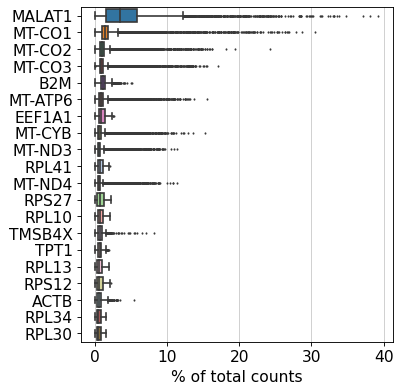

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, ) 

## Basic filtering

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 101 cells that have less than 200 genes expressed
filtered out 13741 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical


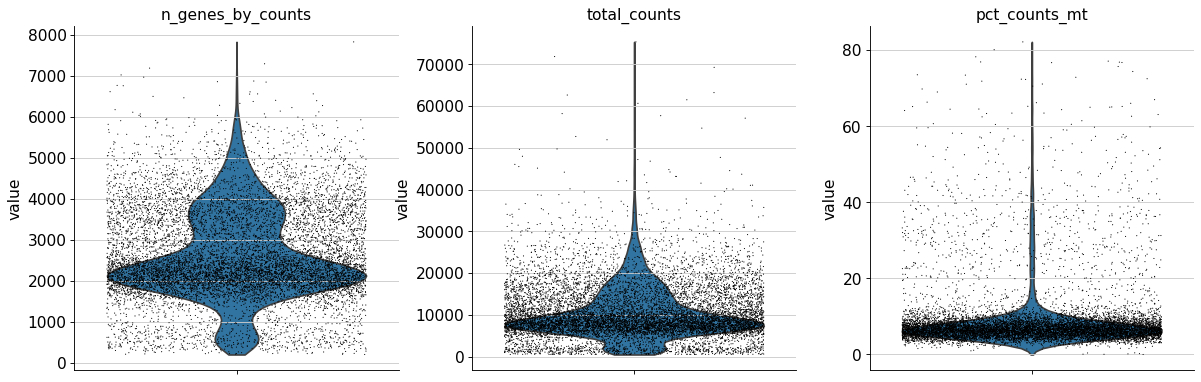

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

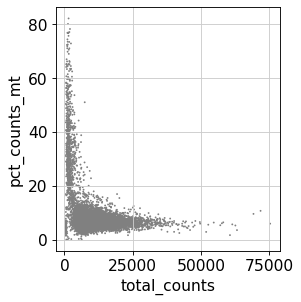

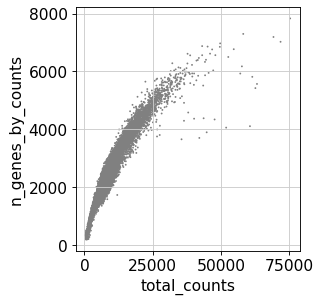

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :]

## normalize

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/wangjl/.local/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


In [15]:
sc.pp.log1p(adata)

## Identify highly-variable genes

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


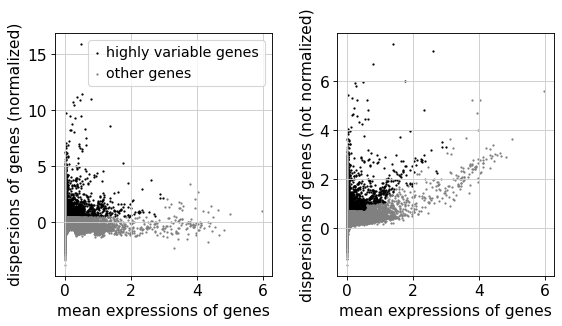

In [17]:
sc.pl.highly_variable_genes(adata)

#### 可选步骤

In [18]:
adata.raw = adata

## Actually do the filtering

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
adata

View of AnnData object with n_obs × n_vars = 10299 × 2307
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## 去掉噪音

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:22)


## scale

In [22]:
sc.pp.scale(adata, max_value=10)

# Principal component analysis

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


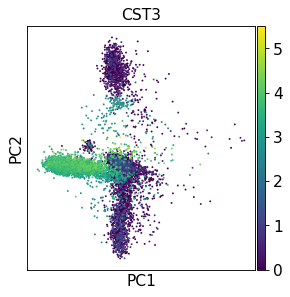

In [24]:
sc.pl.pca(adata, color='CST3')

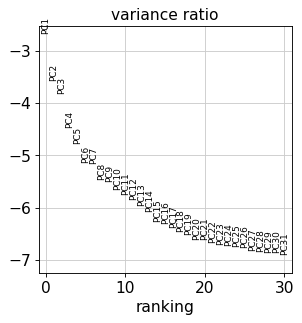

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

## Save the result

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 10299 × 2307
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computing the neighborhood graph

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)


- n_neighbors指的是每个点的邻近点的数量。neighbors的个数越多，聚类数会越少。
- pc的数量依赖于上面所做的碎石图，一般是选在拐点处的的主成分，只需要一个粗略值，不同的pc数量所产生的聚类形状也不同。(一定要大于5，否则分类有问题。)

# UMAP

**Embedding the neighborhood graph**

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 

It is potentially more faithful to the global connectivity of the manifold than tSNE, 
 - i.e., it better preserves trajectories. 
 
In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [30]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


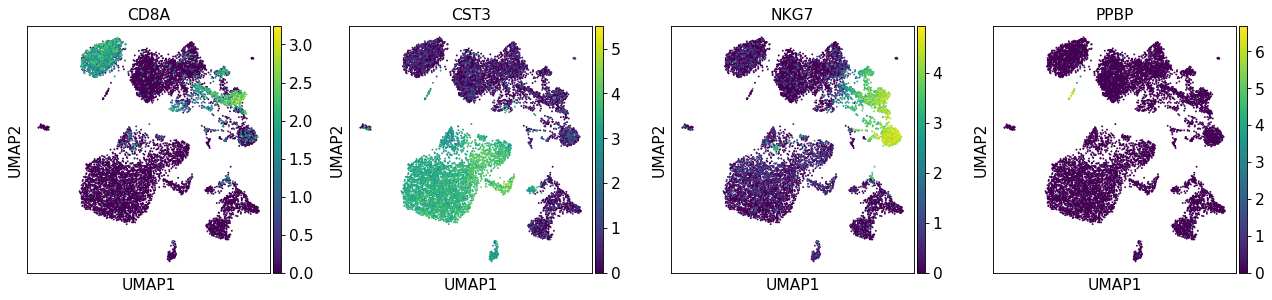

In [31]:
sc.pl.umap(adata, color=['CD8A','CST3', 'NKG7', 'PPBP'])

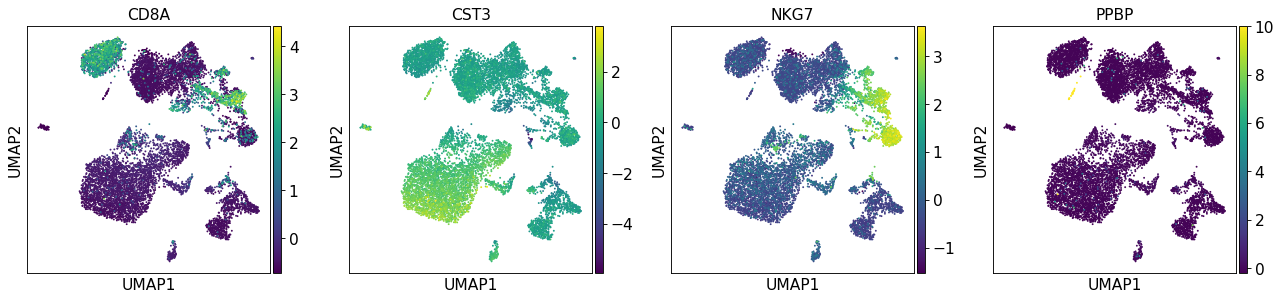

In [32]:
sc.pl.umap(adata, color=['CD8A','CST3', 'NKG7', 'PPBP'], use_raw=False)

# 细胞分类

**Clustering the neighborhood graph**

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). 

Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [35]:
# pip3 install leidenalg
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


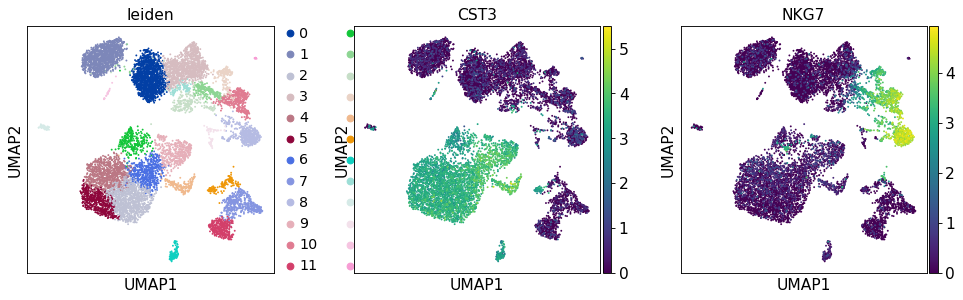

In [38]:
#sc.pl.umap(adata, color=['CD8B'])
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

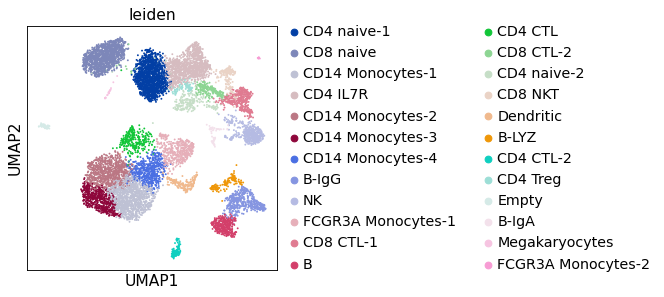

In [108]:
# 后面命名后重新来绘图
sc.pl.umap(adata, color=['leiden'])

## save

In [39]:
adata.write(results_file)

# Finding marker genes

## t-test

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


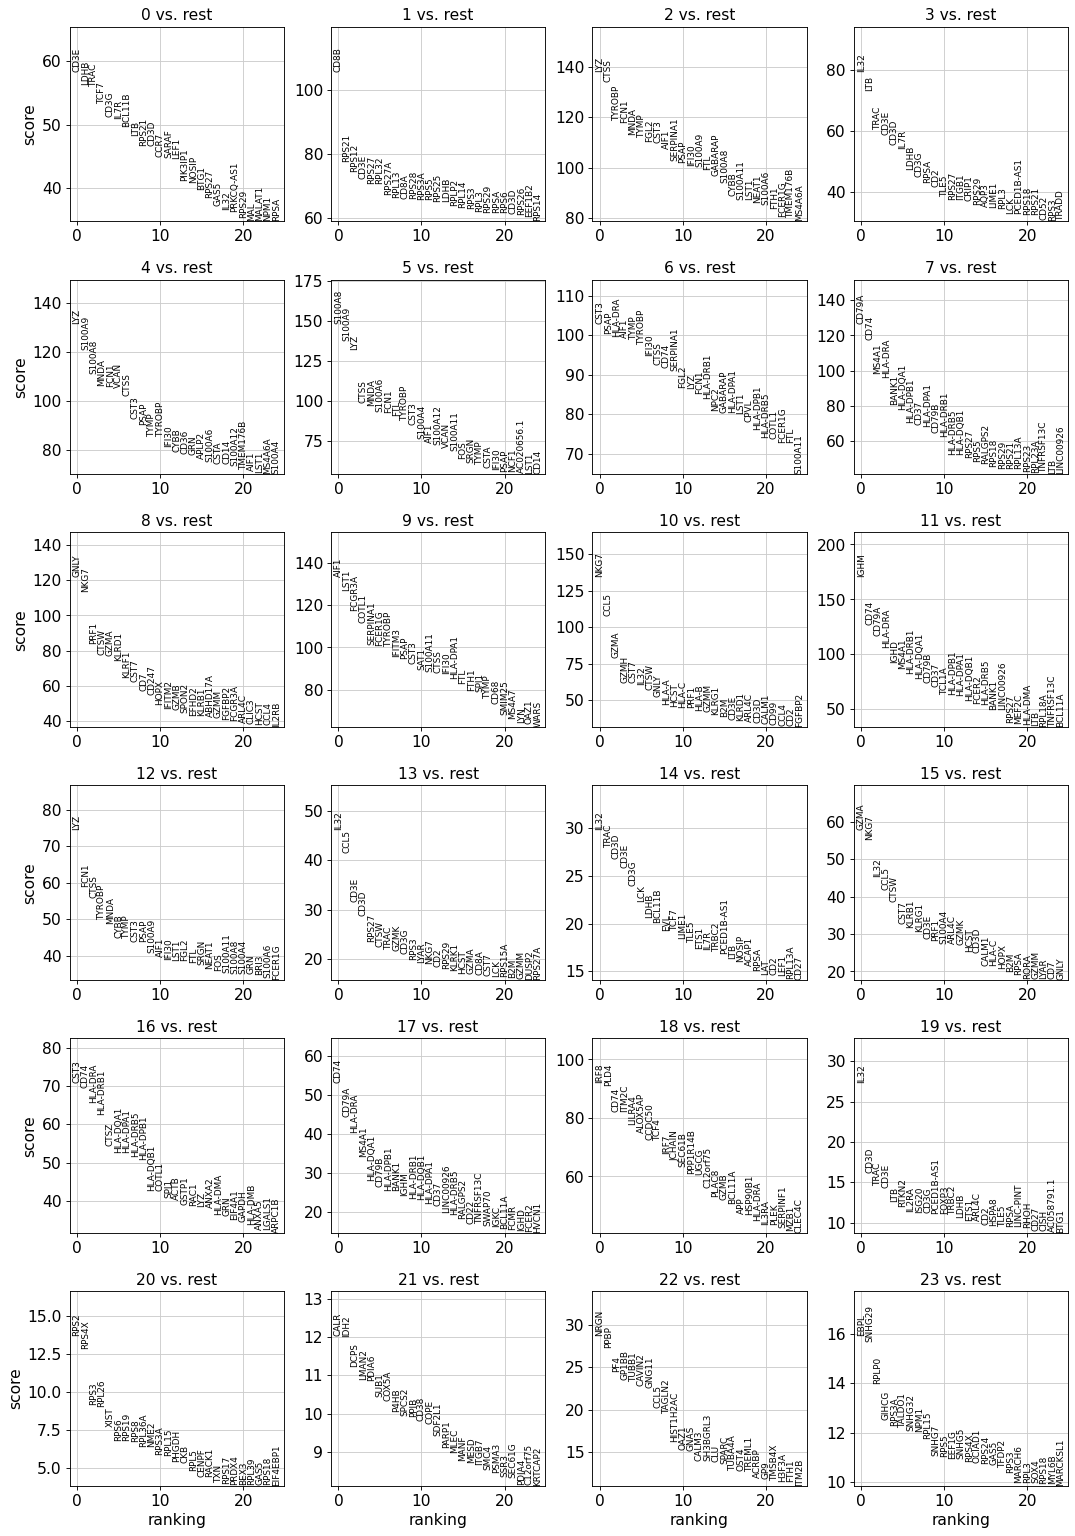

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## wilcoxon

In [41]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:13)


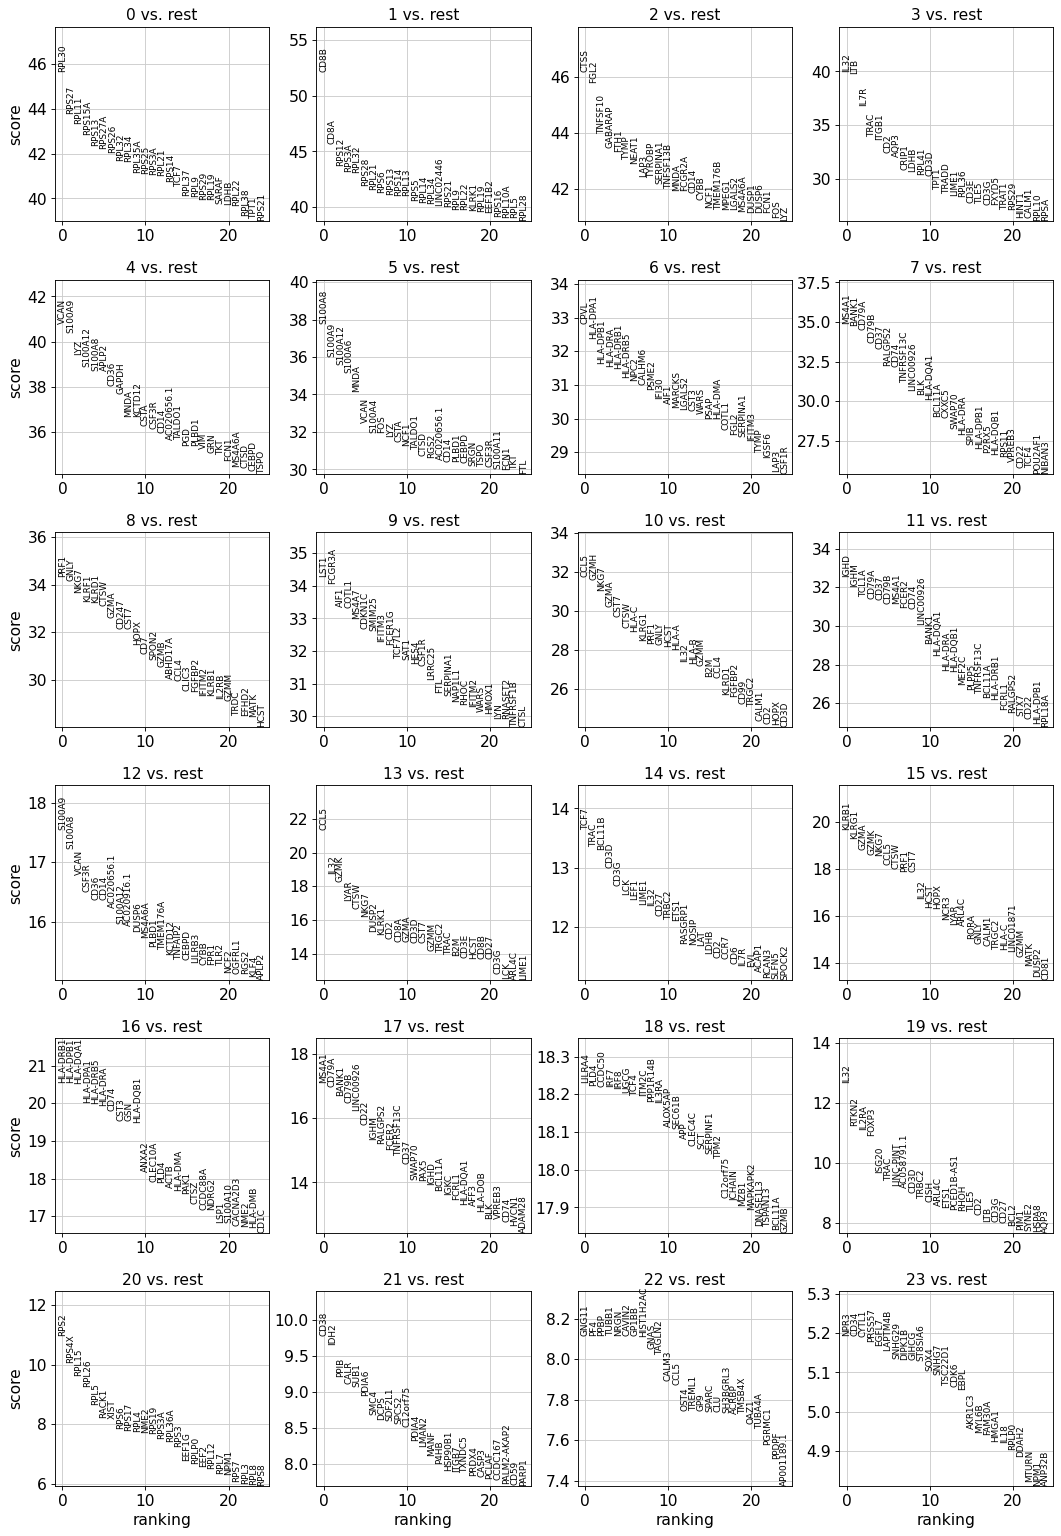

In [42]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

### save

In [43]:
adata.write(results_file)

#### (option)rank genes using logistic regression

ranking genes
/home/wangjl/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished (0:02:25)


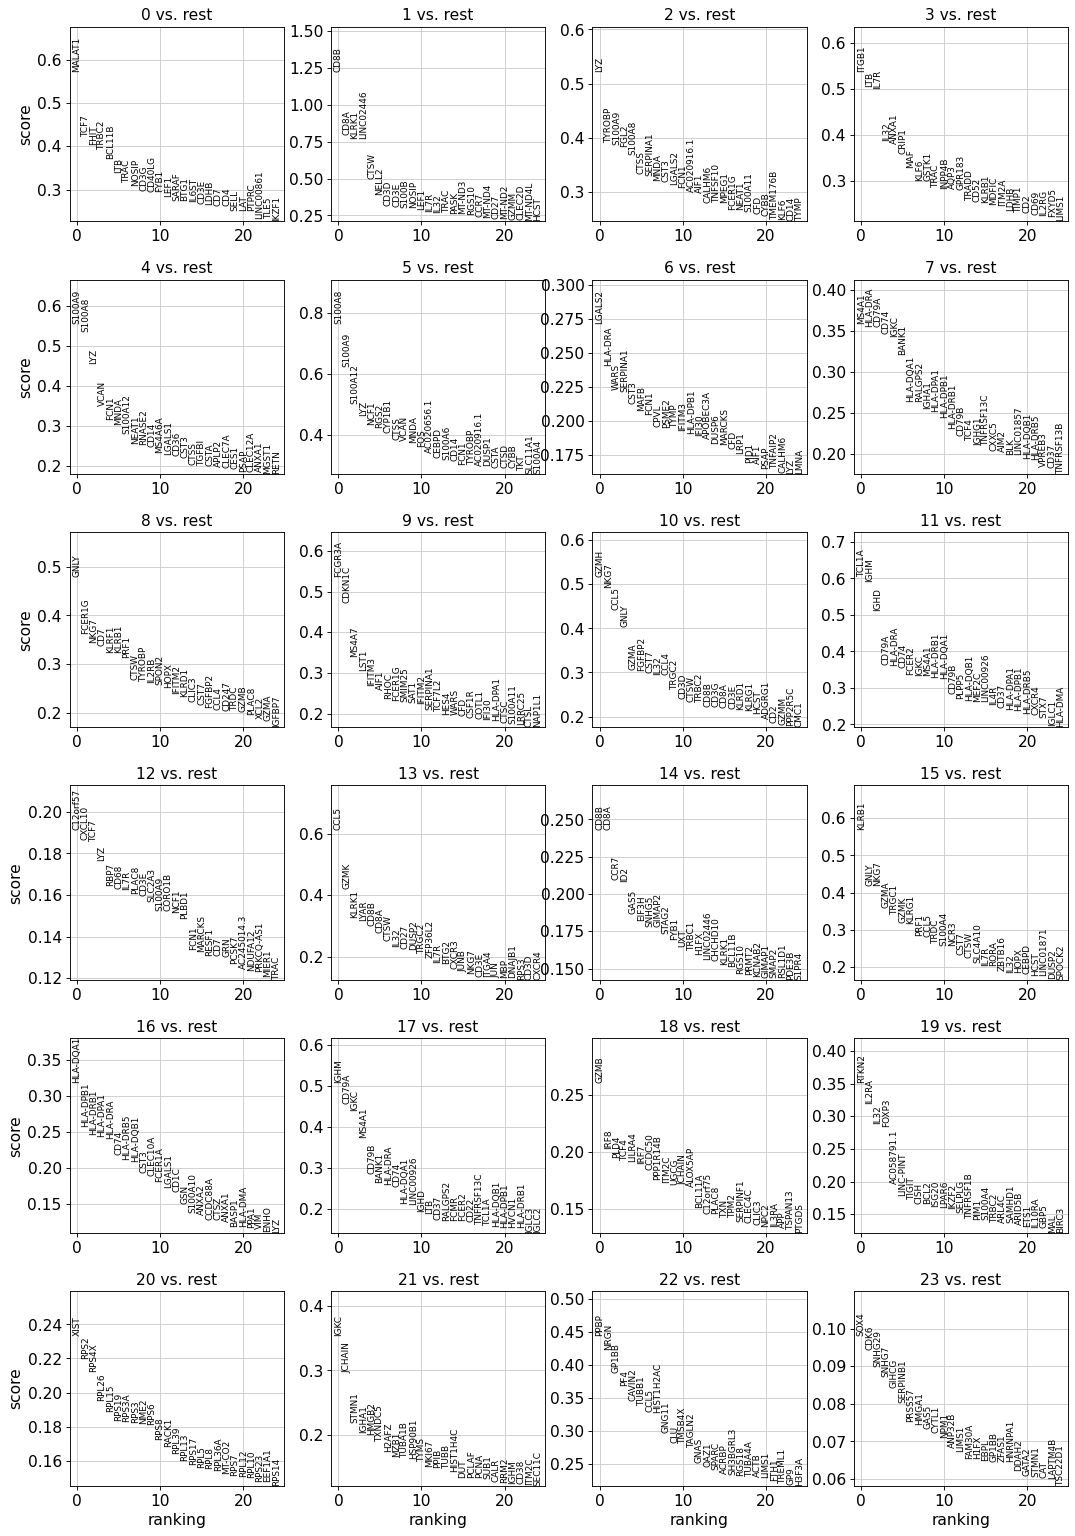

In [44]:
# 耗时 19:58 - 
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## markers

In [45]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [46]:
adata = sc.read(results_file)

In [47]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0      1        2      3        4        5         6      7      8  \
0   RPL30   CD8B     CTSS   IL32     VCAN   S100A8      CPVL  MS4A1   PRF1   
1   RPS27   CD8A     FGL2    LTB   S100A9   S100A9  HLA-DPA1  BANK1   GNLY   
2   RPL11  RPS12  TNFSF10   IL7R      LYZ  S100A12  HLA-DPB1  CD79A   NKG7   
3  RPS15A  RPS3A  GABARAP   TRAC  S100A12   S100A6   HLA-DRA  CD79B  KLRF1   
4   RPS13  RPL32     FTH1  ITGB1   S100A8     MNDA  HLA-DRB1   CD37  KLRD1   

        9  ...      14     15        16         17      18     19     20  \
0    LST1  ...    TCF7  KLRB1  HLA-DRB1      MS4A1  LILRA4   IL32   RPS2   
1  FCGR3A  ...    TRAC  KLRG1  HLA-DPB1      CD79A    PLD4  RTKN2  RPS4X   
2    AIF1  ...  BCL11B   GZMA  HLA-DQA1      BANK1  CCDC50  IL2RA  RPL15   
3   COTL1  ...    CD3D   GZMK  HLA-DPA1      CD79B    IRF7  FOXP3  RPL26   
4   MS4A7  ...    CD3G   NKG7  HLA-DRB5  LINC00926    IRF8  ISG20   RPL5   

     21     22      23  
0  CD38  GNG11    NPR3  
1  IDH2    PF4    CD34  
2  PPIB   PPBP   CYTL1  
3  CALR  TUBB1  PRSS57  
4  SUB1   NRGN   EGFL7  

[5 rows x 24 columns]

Get a table with the scores and groups.

In [48]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p    1_n  1_p      2_n  2_p    3_n            3_p      4_n  4_p  \
0   RPL30  0.0   CD8B  0.0     CTSS  0.0   IL32   0.000000e+00     VCAN  0.0   
1   RPS27  0.0   CD8A  0.0     FGL2  0.0    LTB   0.000000e+00   S100A9  0.0   
2   RPL11  0.0  RPS12  0.0  TNFSF10  0.0   IL7R  5.974994e-297      LYZ  0.0   
3  RPS15A  0.0  RPS3A  0.0  GABARAP  0.0   TRAC  2.438133e-252  S100A12  0.0   
4   RPS13  0.0  RPL32  0.0     FTH1  0.0  ITGB1  2.093910e-248   S100A8  0.0   

   ...   19_n          19_p   20_n          20_p  21_n          21_p   22_n  \
0  ...   IL32  1.026144e-36   RPS2  6.227208e-28  CD38  1.364735e-22  GNG11   
1  ...  RTKN2  2.455434e-29  RPS4X  8.482293e-24  IDH2  4.248062e-22    PF4   
2  ...  IL2RA  1.229295e-28  RPL15  6.501670e-22  PPIB  3.092895e-20   PPBP   
3  ...  FOXP3  1.018904e-27  RPL26  2.170293e-20  CALR  8.053067e-20  TUBB1   
4  ...  ISG20  4.710916e-22   RPL5  5.738092e-18  SUB1  1.127182e-19   NRGN   

           22_p    23_n          23_p  
0  4.859336e-16    NPR3  2.074802e-07  
1  4.859336e-16    CD34  2.074802e-07  
2  4.862209e-16   CYTL1  2.097426e-07  
3  4.862209e-16  PRSS57  2.251757e-07  
4  4.867961e-16   EGFL7  2.379640e-07  

[5 rows x 48 columns]

### Compare to a single cluster

ranking genes
    finished (0:00:01)


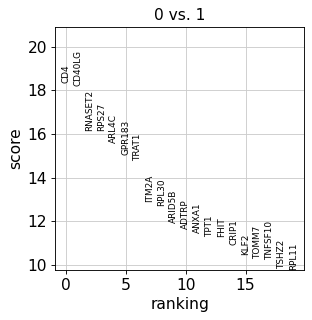

In [49]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

## violin

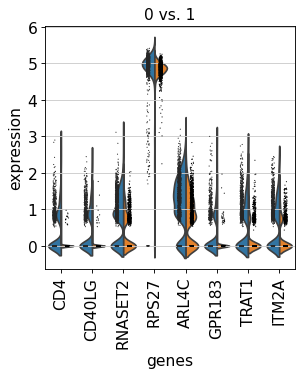

In [50]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

### DE genes

In [51]:
adata = sc.read(results_file)

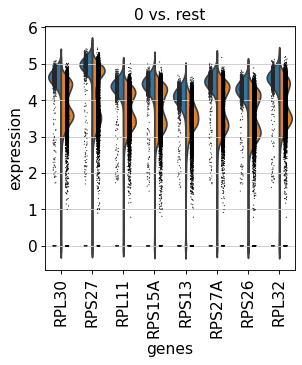

In [52]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

### across groups

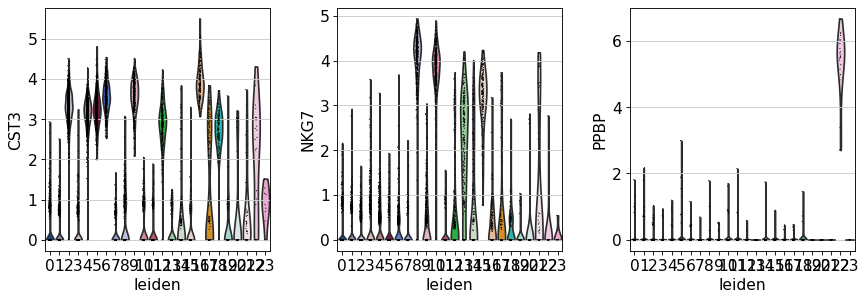

In [53]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

## dot plot

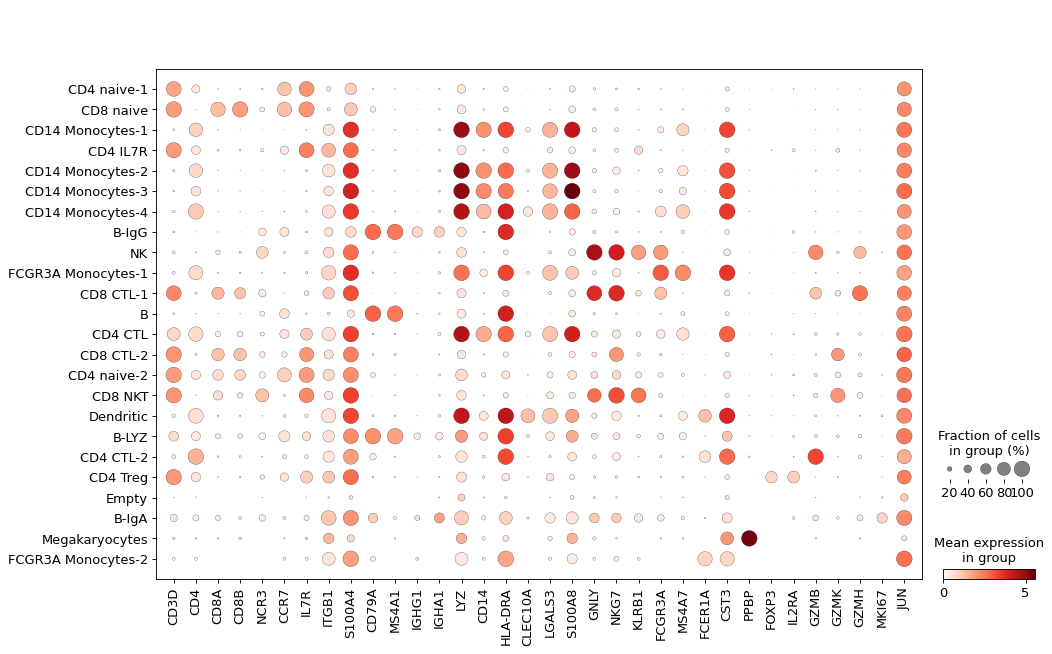

In [96]:
marker_genes2=["CD3D", "CD4", 'CD8A', 'CD8B',"NCR3", #"CD3E",
               "CCR7",'IL7R', "ITGB1", "S100A4",
               'CD79A', 'MS4A1',"IGHG1", "IGHA1", #'CD79B',
               'LYZ', 'CD14',
               "HLA-DRA","CLEC10A",#"HLA-DRB1",
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP',
               "FOXP3","IL2RA", #"RTKN2", 
               "GZMB","GZMK",'GZMH', #,"IFNG"
               "MKI67","JUN"#"FOSB","GAPDH", #"CCNE1","CCNB1",
              ]

sc.pl.dotplot(adata, marker_genes2, groupby='leiden');

# mark the cell types

In [83]:
new_cluster_names = [
    'CD4 naive-1',#0
    "CD8 naive", #1
    
    "CD14 Monocytes-1", #2
    "CD4 IL7R", #3
    "CD14 Monocytes-2", #4,5,6
    "CD14 Monocytes-3",
    "CD14 Monocytes-4",
    
    "B-IgG", #7
    "NK", #8
    'FCGR3A Monocytes-1', #9
    "CD8 CTL-1", #10
    "B", #11
    "CD4 CTL", #12
    "CD8 CTL-2", #13
    "CD4 naive-2", #14
    "CD8 NKT", #15
    "Dendritic", #16
    "B-LYZ", #17
    "CD4 CTL-2", #18
    "CD4 Treg", #19
    "Empty", #20
    "B-IgA", #21
    "Megakaryocytes", #22
    'FCGR3A Monocytes-2' #23
    ]
adata.rename_categories('leiden', new_cluster_names)

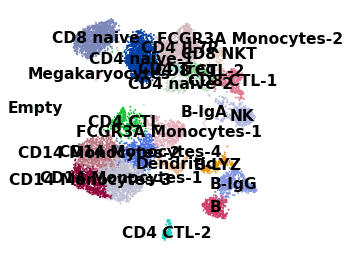

In [86]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save= '.pdf')

## dot plot

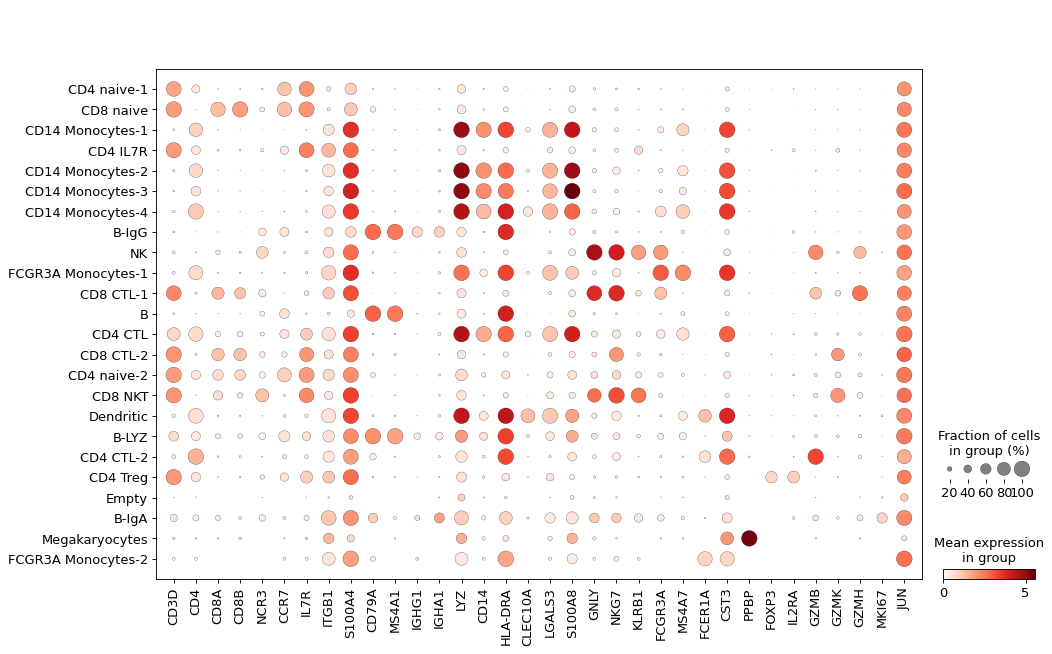

In [97]:
sc.pl.dotplot(adata, marker_genes2, groupby='leiden');

## violin

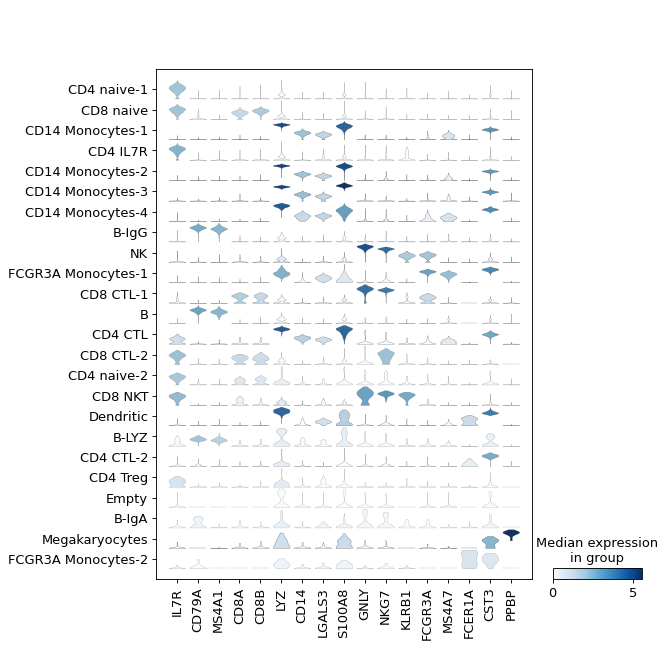

In [98]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

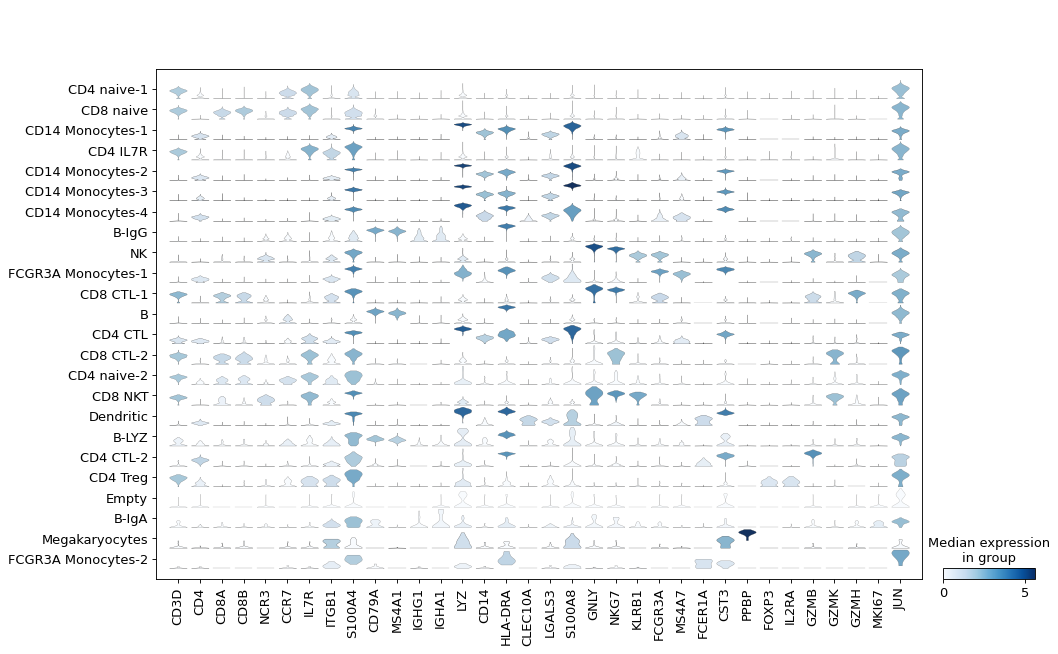

In [99]:
sc.pl.stacked_violin(adata, marker_genes2, groupby='leiden', rotation=90);

In [100]:
adata

AnnData object with n_obs × n_vars = 10299 × 2307
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### save

In [102]:
outputRoot

'/data/wangjl/scScripts/backup/a4/'

In [101]:
adata.write(results_file, compression='gzip')  
# `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [103]:
adata.raw.to_adata().write( outputRoot + 'pbmc10k_after_scanpy.h5ad')

In [105]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTATCGTAC-1      749                749        1628.0              7.0   
AAACCCAGTCGGTGAA-1     1868               1867        6590.0            679.0   
AAACCCAGTTAGAAAC-1     3809               3809       17318.0            951.0   
AAACCCAGTTATCTTC-1     1517               1516        3526.0            476.0   
AAACCCAGTTGCCGAC-1     2110               2110        6228.0            377.0   
...                     ...                ...           ...              ...   
TTTGTTGCAATAGGGC-1     1617               1617        6469.0            315.0   
TTTGTTGCACAGAGAC-1     2427               2426       10290.0            670.0   
TTTGTTGCACAGTCAT-1     2967               2967       10841.0            729.0   
TTTGTTGTCCTAGCTC-1     2241               2241        9062.0            445.0   
TTTGTTGTCCTATGGA-1     4695               4692       23998.0           2491.0   

                    pct_counts_mt              leiden  
AAACCCAGTATCGTAC-1       0.429975    CD14 Monocytes-1  
AAACCCAGTCGGTGAA-1      10.303490             CD8 NKT  
AAACCCAGTTAGAAAC-1       5.491396    CD14 Monocytes-2  
AAACCCAGTTATCTTC-1      13.499716                  NK  
AAACCCAGTTGCCGAC-1       6.053308    CD14 Monocytes-3  
...                           ...                 ...  
TTTGTTGCAATAGGGC-1       4.869377           CD8 naive  
TTTGTTGCACAGAGAC-1       6.511176           CD8 naive  
TTTGTTGCACAGTCAT-1       6.724472    CD14 Monocytes-2  
TTTGTTGTCCTAGCTC-1       4.910616            CD4 IL7R  
TTTGTTGTCCTATGGA-1      10.380032  FCGR3A Monocytes-1  

[10299 rows x 6 columns]

In [106]:
# export to “csv”

# Export single fields of the annotation of observations
adata.obs[['total_counts', 'leiden']].to_csv( outputRoot +  '0_pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv( outputRoot + '0_pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata.write_csvs(results_file[:-5], )

writing .csv files to /data/wangjl/scScripts/backup/a4/01_pbmc10k
